In [104]:
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#import altair as alt
# need to 'pip install vega' before using renderer
#alt.renderers.enable("notebook")
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing,metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA,TruncatedSVD
import scipy
import os
from joblib import dump, load
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as prfs
# test for Selecting The Best Number Of Components For TSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
%matplotlib inline
#fix random seed
np.random.seed(1)

In [105]:
# !jupyter nbextension enable vega --py --sys-prefix

In [106]:
TRAINING_FILE = "../training.csv"
TEST_FILE = "../test.csv"
df = pd.read_csv(TRAINING_FILE)
print(df.isnull().sum())
df.head(5)

article_number    0
article_words     0
topic             0
dtype: int64


,article_number,article_words,topic
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT


In [107]:
new_df = df
train_x = new_df.article_words.apply(lambda x: x.replace('_', ''))
train_y = new_df.topic
le = preprocessing.LabelEncoder()
le.fit(train_y)
encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
en_train_y = le.transform(train_y)
topics = list(set(df['topic']))
TOPIC_COUNT = len(topics)
print(topics)

['IRRELEVANT', 'DEFENCE', 'SHARE LISTINGS', 'HEALTH', 'BIOGRAPHIES PERSONALITIES PEOPLE', 'DOMESTIC MARKETS', 'SCIENCE AND TECHNOLOGY', 'FOREX MARKETS', 'SPORTS', 'MONEY MARKETS', 'ARTS CULTURE ENTERTAINMENT']


In [108]:
smote = SMOTE(random_state=1)
vectorizer = TfidfVectorizer()
vectorizer.fit(train_x)
train_vectors = vectorizer.transform(train_x)
smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
new_train_x = vectorizer.inverse_transform(smo_x)
new_train_x = pd.Series([','.join(item) for item in new_train_x])

In [28]:
# For Tfidf Vectorizer
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
estimators = [
                ("tfidf",TfidfVectorizer(norm=None)),
                ("model",MultinomialNB())
              ]
pipe = Pipeline(estimators)

param_grid = {
                "tfidf__min_df":[i for i in range(1,6)],
                "model__alpha":[0.001,0.01,0.1,1],
                "model__class_prior":[None,[1/len(topics) for i in range(len(topics))]],
                "model__fit_prior":[True,False]
             }
pipe

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm=None,
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('model',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [7]:
# For CountVectorizer
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
estimators = [
                ("count",CountVectorizer()),
                ("model",MultinomialNB())
              ]
pipe = Pipeline(estimators)

param_grid = {
                "count__min_df":[i for i in range(1,6)],
                "model__alpha":[0.001,0.01,0.1,1],
                "model__class_prior":[None,[1/len(topics) for i in range(len(topics))]],
                "model__fit_prior":[True,False]
             }
pipe

Pipeline(memory=None,
         steps=[('count',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('model',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [29]:
%%time
# For Tfidf Vectorizer
grid_search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=-1)

# through in original text samples
grid_result=grid_search.fit(new_train_x, smo_y)
print("The best parameters are {0}, with score {1:4}".format(grid_result.best_params_,grid_result.best_score_))

The best parameters are {'model__alpha': 0.001, 'model__class_prior': None, 'model__fit_prior': True, 'tfidf__min_df': 1}, with score 0.9623997900144465
CPU times: user 52.4 s, sys: 47.8 s, total: 1min 40s
Wall time: 44min 23s


In [9]:
%%time
# For CountVectorizer 
count_grid_search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=-1)

# through in original text samples
count_grid_result=count_grid_search.fit(new_train_x, smo_y)
print("The best parameters are {0}, with score {1:4}".format(count_grid_result.best_params_,count_grid_result.best_score_))

The best parameters are {'count__min_df': 1, 'model__alpha': 0.001, 'model__class_prior': None, 'model__fit_prior': True}, with score 0.957253222723635
CPU times: user 46.1 s, sys: 46.7 s, total: 1min 32s
Wall time: 40min 3s


In [59]:
def get_scores(en_dev_y,pred_y,model_name,topic=None):
    f1 = f1_score(en_dev_y,pred_y,average='macro')
    accuracy = accuracy_score(en_dev_y,pred_y)
    recall = recall_score(en_dev_y,pred_y,average='macro')
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1)
        print("Accuracy score for ",model_name," model is ",accuracy)
        print("Recall score for ",model_name," model is ",recall,"\n")
    else:
        return ([topic,{'accuracy':accuracy,'f1':f1,'recall':recall}])
    
def save_variable(variable,filename):
    file_name = "Models/"+filename+".joblib"
    if not os.path.exists(file_name):
    # Export the model (TFIDF+logistic regressor)
        with open(file_name, "wb") as file:
            dump(variable, file, compress=True)
    else:
        print("Warn: this model already exits...")
        
def retrieve_variable(filename):
    file_name = "Models/"+filename+".joblib"
    return(load(file_name))

In [71]:
clf_NB = grid_result.best_estimator_
acc_train_NB = grid_result.best_score_
print(f"Accuracy on training set: {acc_train_NB:.3f}")
save_variable(clf_NB,"clf_NB")
save_variable(grid_result,"grid_result")

Accuracy on training set: 0.962


In [12]:
clf_count_NB = count_grid_result.best_estimator_
acc_train_count_NB = count_grid_result.best_score_
print(f"Accuracy on training set: {acc_train_count_NB:.3f}")
save_variable(clf_count_NB,"count_clf_NB")
save_variable(count_grid_result,"count_grid_result")

Accuracy on training set: 0.957
Warn: this model already exits...


In [13]:
df_test = pd.read_csv(TEST_FILE)
print(df_test.isnull().sum())
df_test.head(5)

article_number    0
article_words     0
topic             0
dtype: int64


,article_number,article_words,topic
0,9501,"world,complet,pharmaceut,tianjin,tianjin,chin,...",IRRELEVANT
1,9502,"copy,sunday,weekend,ec,friday,eu,includ,limit,...",IRRELEVANT
2,9503,"heavy,heavy,gabriel,morn,morn,equit,cent,cent,...",FOREX MARKETS
3,9504,"research,jess,hit,anticip,comput,comput,comput...",IRRELEVANT
4,9505,"provid,provid,luxembourg,court,court,case,opin...",IRRELEVANT


In [19]:
test_x = df_test.article_words.apply(lambda x: x.replace('_', ''))
test_y = df_test.topic
en_test_y = le.transform(test_y)
y_pred = clf_NB.predict(test_x)
train_y_pred = clf_NB.predict(train_x)

In [20]:
count_y_pred = clf_count_NB.predict(test_x)
count_train_y_pred = clf_count_NB.predict(train_x)

In [48]:
get_scores(en_test_y,y_pred,"MultinomialNB")

F1 score for  MultinomialNB  model is  0.4556854016224356
Accuracy score for  MultinomialNB  model is  0.724
Recall score for  MultinomialNB  model is  0.4394210671098543 



In [18]:
get_scores(en_test_y,count_y_pred,"MultinomialNB")

F1 score for  MultinomialNB  model is  0.46308661984185123
Accuracy score for  MultinomialNB  model is  0.714
Recall score for  MultinomialNB  model is  0.47012121174020494 



In [50]:
get_scores(en_train_y,train_y_pred,"nb")

F1 score for  nb  model is  0.9263915215365351
Accuracy score for  nb  model is  0.9076842105263158
Recall score for  nb  model is  0.9577271650650196 



In [21]:
get_scores(en_train_y,count_train_y_pred,"nb")

F1 score for  nb  model is  0.9009392597460851
Accuracy score for  nb  model is  0.8831578947368421
Recall score for  nb  model is  0.9476487451268478 



In [53]:
print(encode_mapping)
print(f"Classification Report:\n{classification_report(en_test_y, y_pred)}")

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       1.00      0.13      0.24        15
           2       0.86      0.46      0.60        13
           3       0.33      0.50      0.40         2
           4       0.36      0.33      0.34        48
           5       0.86      0.43      0.57        14
           6       0.82      0.84      0.83       266
           7       0.52      0.70      0.60        69
           8       0.00      0.00      0.00         3
           9       0.17      0.14      0.15         7
          10       0.94      0.97      0.95        60

    accuracy                           0.72       500
   macro avg       0.56      

In [22]:
print(f"Classification Report:\n{classification_report(en_test_y, count_y_pred)}")

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       1.00      0.13      0.24        15
           2       0.86      0.46      0.60        13
           3       0.20      0.50      0.29         2
           4       0.35      0.35      0.35        48
           5       0.83      0.71      0.77        14
           6       0.84      0.78      0.81       266
           7       0.48      0.75      0.59        69
           8       0.00      0.00      0.00         3
           9       0.14      0.14      0.14         7
          10       0.95      1.00      0.98        60

    accuracy                           0.71       500
   macro avg       0.55      0.47      0.46       500
weighted avg       0.74      0.71      0.71       500



### Accuracy of Topics

In [23]:
def scores_for_topics(df,topics,model,le):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

def topic_scores(df,topic,model,le,scores):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.article_words.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    #le.fit(train_y)
    en_test_y = le.transform(test_y)
    prediction = model.predict(test_x)
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))
    
scores_for_topics(df_test,topics,clf_NB,le)

['SPORTS', {'accuracy': 0.9666666666666667, 'f1': 0.4915254237288135, 'recall': 0.48333333333333334}]
['IRRELEVANT', {'accuracy': 0.8383458646616542, 'f1': 0.1140081799591002, 'recall': 0.10479323308270677}]
['MONEY MARKETS', {'accuracy': 0.6956521739130435, 'f1': 0.2735042735042735, 'recall': 0.2318840579710145}]
['DOMESTIC MARKETS', {'accuracy': 0.5, 'f1': 0.3333333333333333, 'recall': 0.25}]
['DEFENCE', {'accuracy': 0.46153846153846156, 'f1': 0.3157894736842105, 'recall': 0.23076923076923078}]
['HEALTH', {'accuracy': 0.42857142857142855, 'f1': 0.3, 'recall': 0.21428571428571427}]
['FOREX MARKETS', {'accuracy': 0.3333333333333333, 'f1': 0.16666666666666666, 'recall': 0.1111111111111111}]
['ARTS CULTURE ENTERTAINMENT', {'accuracy': 0.3333333333333333, 'f1': 0.25, 'recall': 0.16666666666666666}]
['SHARE LISTINGS', {'accuracy': 0.14285714285714285, 'f1': 0.125, 'recall': 0.07142857142857142}]
['BIOGRAPHIES PERSONALITIES PEOPLE', {'accuracy': 0.13333333333333333, 'f1': 0.0588235294117647

In [24]:
scores_for_topics(df_test,topics,clf_count_NB,le)

['SPORTS', {'accuracy': 1.0, 'f1': 1.0, 'recall': 1.0}]
['IRRELEVANT', {'accuracy': 0.7781954887218046, 'f1': 0.10940803382663848, 'recall': 0.09727443609022557}]
['MONEY MARKETS', {'accuracy': 0.7536231884057971, 'f1': 0.2865013774104683, 'recall': 0.25120772946859904}]
['HEALTH', {'accuracy': 0.7142857142857143, 'f1': 0.41666666666666663, 'recall': 0.35714285714285715}]
['DOMESTIC MARKETS', {'accuracy': 0.5, 'f1': 0.3333333333333333, 'recall': 0.25}]
['DEFENCE', {'accuracy': 0.46153846153846156, 'f1': 0.3157894736842105, 'recall': 0.23076923076923078}]
['FOREX MARKETS', {'accuracy': 0.3541666666666667, 'f1': 0.17435897435897438, 'recall': 0.11805555555555557}]
['ARTS CULTURE ENTERTAINMENT', {'accuracy': 0.3333333333333333, 'f1': 0.25, 'recall': 0.16666666666666666}]
['SHARE LISTINGS', {'accuracy': 0.14285714285714285, 'f1': 0.125, 'recall': 0.07142857142857142}]
['BIOGRAPHIES PERSONALITIES PEOPLE', {'accuracy': 0.13333333333333333, 'f1': 0.0784313725490196, 'recall': 0.04444444444444

In [72]:
conf_matrix = confusion_matrix(en_test_y, y_pred)
print(conf_matrix)

[[  1   0   0   0   0   0   2   0   0   0   0]
 [  1   2   0   0   0   0  11   0   0   0   1]
 [  0   0   6   0   0   0   7   0   0   0   0]
 [  0   0   0   1   0   0   1   0   0   0   0]
 [  0   0   0   0  16   0   7  25   0   0   0]
 [  0   0   0   0   0   6   8   0   0   0   0]
 [  0   0   1   2  12   1 223  19   0   5   3]
 [  0   0   0   0  17   0   4  48   0   0   0]
 [  1   0   0   0   0   0   2   0   0   0   0]
 [  0   0   0   0   0   0   6   0   0   1   0]
 [  0   0   0   0   0   0   2   0   0   0  58]]


In [25]:
count_conf_matrix = confusion_matrix(en_test_y, count_y_pred)
print(count_conf_matrix)

[[  1   0   0   0   0   0   2   0   0   0   0]
 [  1   2   0   0   0   0  12   0   0   0   0]
 [  0   0   6   0   0   0   7   0   0   0   0]
 [  0   0   0   1   0   0   1   0   0   0   0]
 [  0   0   0   0  17   0   4  27   0   0   0]
 [  0   0   0   0   0  10   4   0   0   0   0]
 [  0   0   1   4  15   1 207  29   0   6   3]
 [  0   0   0   0  16   0   1  52   0   0   0]
 [  1   0   0   0   0   1   1   0   0   0   0]
 [  0   0   0   0   0   0   6   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0  60]]


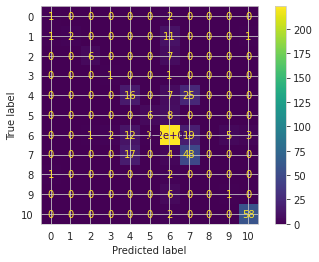

In [80]:
plot_confusion_matrix(clf_NB,test_x,en_test_y)

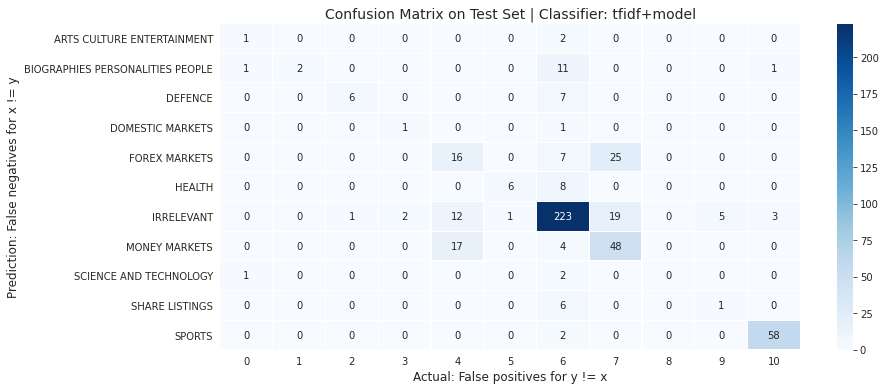

In [74]:
fig1 = plt.figure(figsize=(13,6))
sns.heatmap(conf_matrix,
#             square=True,
            annot=True, # show numbers in each cell
            fmt='d', # set number format to integer in each cell
            yticklabels=le.classes_,
            xticklabels=clf_NB.classes_,
            cmap="Blues",
#             linecolor="k",
            linewidths=.1,
           )
plt.title(
          f"Confusion Matrix on Test Set | " 
          f"Classifier: {'+'.join([step for step in clf_NB.named_steps.keys()])}", 
          fontsize=14)
plt.xlabel("Actual: False positives for y != x", fontsize=12)
plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
plt.show()

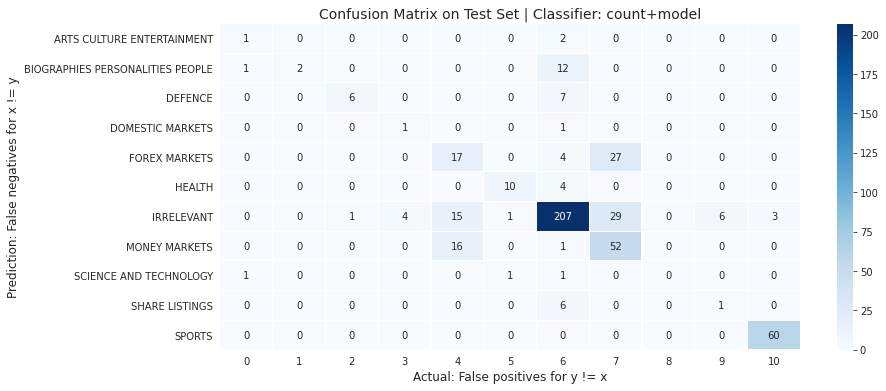

In [26]:
fig1 = plt.figure(figsize=(13,6))
sns.heatmap(count_conf_matrix,
#             square=True,
            annot=True, # show numbers in each cell
            fmt='d', # set number format to integer in each cell
            yticklabels=le.classes_,
            xticklabels=clf_count_NB.classes_,
            cmap="Blues",
#             linecolor="k",
            linewidths=.1,
           )
plt.title(
          f"Confusion Matrix on Test Set | " 
          f"Classifier: {'+'.join([step for step in clf_count_NB.named_steps.keys()])}", 
          fontsize=14)
plt.xlabel("Actual: False positives for y != x", fontsize=12)
plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
plt.show()

In [75]:
print(encode_mapping)

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}


In [15]:
clf_NB = retrieve_variable("clf_NB")


## Test of Two Layer Model

In [109]:
new_df = df
rel_topic = [] # relevance topic
for i in range(new_df.shape[0]):
    if(new_df.topic.iloc[i]=="IRRELEVANT"):
        rel_topic.append("IRRELEVANT")
    else:
        rel_topic.append("RELEVANT")
new_df['rel_topic']=rel_topic
new_df

,article_number,article_words,topic,rel_topic
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS,RELEVANT
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS,RELEVANT
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS,RELEVANT
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS,RELEVANT
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT,IRRELEVANT
...,...,...,...,...
9495,9496,"cloud,provid,hope,centur,erupt,rule,recent,sou...",DEFENCE,RELEVANT
9496,9497,"stock,stock,stock,declin,access,week,worry,blo...",IRRELEVANT,IRRELEVANT
9497,9498,"rate,million,million,belarus,dollar,dollar,nov...",FOREX MARKETS,RELEVANT
9498,9499,"flow,bullet,bullet,bullet,bullet,bullet,bullet...",IRRELEVANT,IRRELEVANT


In [110]:
train_x = new_df.article_words.apply(lambda x: x.replace('_', ''))
rel_train_y = new_df.rel_topic
rel_le = preprocessing.LabelEncoder()
rel_le.fit(rel_train_y)
rel_encode_mapping = dict(zip(rel_le.classes_, range(len(rel_le.classes_))))
en_rel_train_y = rel_le.transform(rel_train_y)

In [111]:
smote = SMOTE(random_state=1)
vectorizer = TfidfVectorizer()
vectorizer.fit(train_x)
train_vectors = vectorizer.transform(train_x)
smo_x,rel_smo_y = smote.fit_sample(train_vectors,en_rel_train_y)
new_train_x = vectorizer.inverse_transform(smo_x)
new_train_x = pd.Series([','.join(item) for item in new_train_x])

#### First Layer with Tfidf

In [57]:
# For Tfidf Vectorizer
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
rel_estimators = [
                ("tfidf",TfidfVectorizer(norm=None)),
                ("model",MultinomialNB())
              ]
rel_pipe = Pipeline(rel_estimators)

rel_param_grid = {
                "tfidf__min_df":[i for i in range(1,6)],
                "model__alpha":[0.001,0.01,0.1,1],
                "model__class_prior":[None,[1/len(topics) for i in range(len(topics))]],
                "model__fit_prior":[True,False]
             }
rel_pipe

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm=None,
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('model',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [58]:
%%time
# For Tfidf Vectorizer
rel_grid_search = GridSearchCV(rel_pipe, rel_param_grid, cv=kfold, n_jobs=-1)

# through in original text samples
rel_grid_result=rel_grid_search.fit(new_train_x, rel_smo_y)
print("The best parameters are {0}, with score {1:4}".format(rel_grid_result.best_params_,rel_grid_result.best_score_))

The best parameters are {'model__alpha': 1, 'model__class_prior': None, 'model__fit_prior': True, 'tfidf__min_df': 1}, with score 0.8327742470538804
CPU times: user 6.29 s, sys: 824 ms, total: 7.12 s
Wall time: 3min 59s


In [61]:
rel_clf_NB = rel_grid_result.best_estimator_
rel_acc_train_NB = rel_grid_result.best_score_
print(f"Accuracy on training set: {rel_acc_train_NB:.3f}")
save_variable(rel_clf_NB,"rel_clf_NB")
save_variable(rel_grid_result,"rel_grid_result")

Accuracy on training set: 0.833


#### First Layer With CountVetorizer

In [62]:
# For CountVectorizer
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
rel_count_estimators = [
                ("count",CountVectorizer()),
                ("model",MultinomialNB())
              ]
rel_count_pipe = Pipeline(rel_count_estimators)

rel_count_param_grid = {
                "count__min_df":[i for i in range(1,6)],
                "model__alpha":[0.001,0.01,0.1,1],
                "model__class_prior":[None,[1/len(topics) for i in range(len(topics))]],
                "model__fit_prior":[True,False]
             }
rel_count_pipe

Pipeline(memory=None,
         steps=[('count',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('model',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [63]:
%%time
# For CountVectorizer 
rel_count_grid_search = GridSearchCV(rel_count_pipe, rel_count_param_grid, cv=kfold, n_jobs=-1)

# through in original text samples
rel_count_grid_result=rel_count_grid_search.fit(new_train_x, rel_smo_y)
print("The best parameters are {0}, with score {1:4}".format(rel_count_grid_result.best_params_,rel_count_grid_result.best_score_))

The best parameters are {'count__min_df': 3, 'model__alpha': 0.1, 'model__class_prior': None, 'model__fit_prior': True}, with score 0.8369710788616329
CPU times: user 6.21 s, sys: 912 ms, total: 7.12 s
Wall time: 3min 59s


In [64]:
rel_count_clf_NB = rel_count_grid_result.best_estimator_
rel_count_acc_train_NB = rel_count_grid_result.best_score_
print(f"Accuracy on training set: {rel_count_acc_train_NB:.3f}")
save_variable(rel_count_clf_NB,"rel_count_clf_NB")
save_variable(rel_count_grid_result,"rel_count_grid_result")

Accuracy on training set: 0.837


Therefore, we chooes the CountVectorizer for the first layer.

### Second Layer Model

In [112]:
new_df = df[df.topic!="IRRELEVANT"]
train_x = new_df.article_words.apply(lambda x: x.replace('_', ''))
train_y = new_df.topic
en_train_y = le.transform(train_y)
topics = list(set(new_df['topic']))
TOPIC_COUNT = len(topics)
print(topics)

['DEFENCE', 'SHARE LISTINGS', 'HEALTH', 'BIOGRAPHIES PERSONALITIES PEOPLE', 'DOMESTIC MARKETS', 'SCIENCE AND TECHNOLOGY', 'FOREX MARKETS', 'SPORTS', 'MONEY MARKETS', 'ARTS CULTURE ENTERTAINMENT']


In [113]:
smote = SMOTE(random_state=1)
vectorizer = TfidfVectorizer()
vectorizer.fit(train_x)
train_vectors = vectorizer.transform(train_x)
smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
new_train_x = vectorizer.inverse_transform(smo_x)
new_train_x = pd.Series([','.join(item) for item in new_train_x])
print(new_train_x.shape)
print(smo_y.shape)

(16730,)
(16730,)


In [114]:
# For Tfidf Vectorizer
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
estimators = [
                ("tfidf",TfidfVectorizer(norm=None)),
                ("model",MultinomialNB())
              ]
pipe = Pipeline(estimators)

param_grid = {
                "tfidf__min_df":[i for i in range(1,6)],
                "model__alpha":[0.001,0.01,0.1,1],
                "model__class_prior":[None,[1/len(topics) for i in range(len(topics))]],
                "model__fit_prior":[True,False]
             }
pipe

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm=None,
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('model',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [115]:
%%time
# For Tfidf Vectorizer
grid_search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=-1)

# through in original text samples
grid_result=grid_search.fit(new_train_x, smo_y)
print("The best parameters are {0}, with score {1:4}".format(grid_result.best_params_,grid_result.best_score_))

The best parameters are {'model__alpha': 0.001, 'model__class_prior': None, 'model__fit_prior': True, 'tfidf__min_df': 1}, with score 0.9479976090854751
CPU times: user 14.8 s, sys: 3.16 s, total: 18 s
Wall time: 13min 28s


In [117]:
clf_NB = grid_result.best_estimator_
acc_train_NB = grid_result.best_score_
print(f"Accuracy on training set: {acc_train_NB:.3f}")
save_variable(clf_NB,"second_layer_clf_tfidf_NB")
save_variable(grid_result,"second_layer_tfidf_grid_result")

Accuracy on training set: 0.948


In [118]:
# For CountVectorizer
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
estimators = [
                ("count",CountVectorizer()),
                ("model",MultinomialNB())
              ]
pipe = Pipeline(estimators)

param_grid = {
                "count__min_df":[i for i in range(1,6)],
                "model__alpha":[0.001,0.01,0.1,1],
                "model__class_prior":[None,[1/len(topics) for i in range(len(topics))]],
                "model__fit_prior":[True,False]
             }
pipe

Pipeline(memory=None,
         steps=[('count',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('model',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [119]:
%%time
# For CountVectorizer 
count_grid_search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=-1)

# through in original text samples
count_grid_result=count_grid_search.fit(new_train_x, smo_y)
print("The best parameters are {0}, with score {1:4}".format(count_grid_result.best_params_,count_grid_result.best_score_))

The best parameters are {'count__min_df': 1, 'model__alpha': 0.001, 'model__class_prior': None, 'model__fit_prior': True}, with score 0.9450089659294681
CPU times: user 14.7 s, sys: 2.88 s, total: 17.5 s
Wall time: 12min 52s


In [121]:
clf_count_NB = count_grid_result.best_estimator_
acc_count_train_NB = count_grid_result.best_score_
print(f"Accuracy on training set: {acc_count_train_NB:.3f}")
save_variable(clf_count_NB,"second_layer_clf_count_NB")
save_variable(count_grid_result,"second_layer_count_grid_result")

Accuracy on training set: 0.945


Therefore, the second layer would be using the tfidf vectorizer.

#### Test Set at First Layer

In [123]:
df_test = pd.read_csv(TEST_FILE)
rel_topic = [] # relevance topic
for i in range(df_test.shape[0]):
    if(df_test.topic.iloc[i]=="IRRELEVANT"):
        rel_topic.append("IRRELEVANT")
    else:
        rel_topic.append("RELEVANT")
df_test['rel_topic']=rel_topic
test_x = df_test.article_words.apply(lambda x: x.replace('_', ''))
rel_test_y = df_test.rel_topic
en_rel_test_y = rel_le.transform(rel_test_y)
rel_y_pred = rel_count_clf_NB.predict(test_x)
get_scores(en_rel_test_y,rel_y_pred,"MultinomialNB for Relevance")

F1 score for  MultinomialNB for Relevance  model is  0.8255639097744362
Accuracy score for  MultinomialNB for Relevance  model is  0.826
Recall score for  MultinomialNB for Relevance  model is  0.8261840498682604 



#### Test Set at Second Layer

In [124]:
rel_y_pred = rel_le.inverse_transform(rel_y_pred)
df_test['rel_pred']=rel_y_pred
df_test

,article_number,article_words,topic,rel_topic,rel_pred
0,9501,"world,complet,pharmaceut,tianjin,tianjin,chin,...",IRRELEVANT,IRRELEVANT,IRRELEVANT
1,9502,"copy,sunday,weekend,ec,friday,eu,includ,limit,...",IRRELEVANT,IRRELEVANT,IRRELEVANT
2,9503,"heavy,heavy,gabriel,morn,morn,equit,cent,cent,...",FOREX MARKETS,RELEVANT,RELEVANT
3,9504,"research,jess,hit,anticip,comput,comput,comput...",IRRELEVANT,IRRELEVANT,IRRELEVANT
4,9505,"provid,provid,luxembourg,court,court,case,opin...",IRRELEVANT,IRRELEVANT,IRRELEVANT
...,...,...,...,...,...
495,9996,"symantec,soon,interfac,provid,provid,comput,co...",IRRELEVANT,IRRELEVANT,IRRELEVANT
496,9997,"hit,hit,hit,hit,hit,hit,hit,hit,hit,beat,beat,...",SPORTS,RELEVANT,RELEVANT
497,9998,"cent,cent,cent,cent,match,declin,act,rate,rate...",MONEY MARKETS,RELEVANT,RELEVANT
498,9999,"cnmv,cnmv,stock,count,count,week,group,friday,...",SHARE LISTINGS,RELEVANT,RELEVANT


In [126]:
new_df_test = df_test[df_test.rel_pred!="IRRELEVANT"]
test_x = new_df_test.article_words.apply(lambda x: x.replace('_', ''))
topic_test_y = new_df_test.topic
en_topic_test_y = le.transform(topic_test_y)
topic_y_pred = clf_NB.predict(test_x)
get_scores(en_topic_test_y,topic_y_pred,"MultinomialNB for Topic")

F1 score for  MultinomialNB for Topic  model is  0.5210359214428982
Accuracy score for  MultinomialNB for Topic  model is  0.5850622406639004
Recall score for  MultinomialNB for Topic  model is  0.613816425120773 



In [129]:
print(test_x.shape,en_topic_test_y.shape)

(241,) (241,)
